# SyNBEARTS Example Usage

This is a Jupyter notebook that gives some examples of using the SyNBEATS package. It uses annual state-level panel data of cigarette sales for the period 1970 - 2000 and aims to estimate the effect of Proposition 99 on cigarette sales in California. Specifically, it trains a model to predict cigarette sales per capita in California during years prior to 1989, and apply the model out-of-sample to predict California cigarette sales per capita in 1989 onward.

First you need to install the dependencies

In [ ]:
%pip install -r requirements.txt

In [5]:
from SyNBEATS import *  # import the package
import pandas as pd
from tqdm.auto import tqdm

# read data and preprocess the column names into ["id", "time", "Y_obs"]
dta = pd.read_csv("smoking_data.csv")
dta = dta[["state", "year", "cigsale"]]
dta.columns = ["id", "time", "Y_obs"]

# create a SyNBEATS model. 3 is the index of California, and 1989 is the target time.
# The model will be trained with data for California before 1989 and will predict 
model = SyNBEATS(dta, [3], 1989)

Next we can train the model by calling `model.train()`. There are several parameters you can set to control the training process, and you can also set if you want to use CPU or GPU to train. You can find detailed explanation of the parameters in `README.md` in the [Github repo](https://github.com/Crabtain959/SyNBEATS). Here we train the model with default parameters and 1 GPU. 

In [6]:
model.train(use_gpu=1)


  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.278    Total estimated model params size (MB)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


After training the model, the SyNBEATS object (the `model` variable) now has the predictions. You can use `model.predictions()` to get the predictions in Darts TimeSeries, or you can use `model.predictions(df=True)` to get them in Pandas DataFrame. You can also plot the predictions and the gap with the following commands:

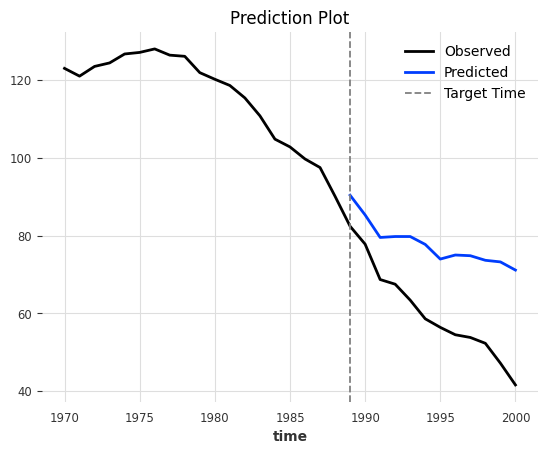

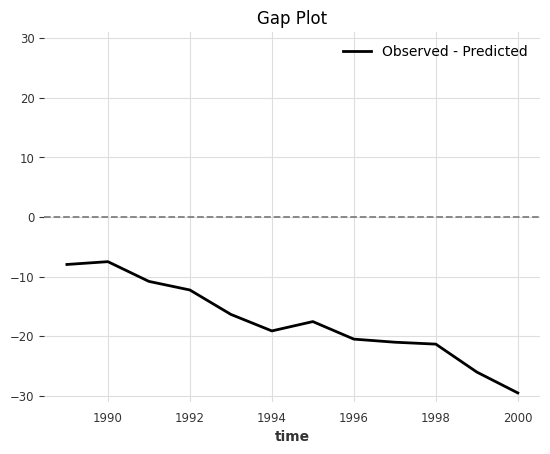

In [7]:
model.plot_predictions()
model.plot_gap()

You can also easily calculate the average treatment effect (ATE) and the standard deviation of the treatment effects

In [5]:
ate = model.average_treatment_effect()
std = model.std_treatment_effect()
ate, std

(-15.747705998677214, 6.458843984885096)

### Placebo Test

We also include a placebo text function that helps you perform a placebo test with one function call. Like the function `train`, you can also set a set of parameters to control the process, as well as the placebo units you would like to use. Here we use states with index from 4 to 14 as placebo units and run it with 1 GPU. The function will return the predictions for each placebo unit and a p-value

Starting the placebo test...


Processing placebo for control id 14: 100%|██████████| 11/11 [12:26<00:00, 67.86s/it]

Placebo test completed.


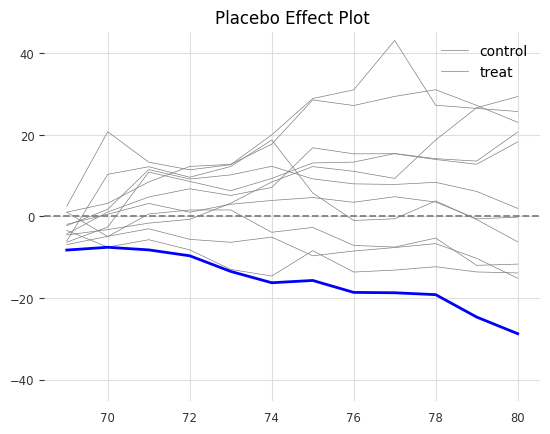

0.013765355445207184

In [6]:
placebo_predictions, p_value = model.placebo_test(control_ids=[str(i) for i in range(4,15)], use_gpu=1)
p_value